In [1]:
%matplotlib inline
import sys
sys.path.append("../") # go to parent dir

import numpy as np
import torch
import matplotlib.pyplot as plt
import mpmath

from synthetic.generate import SingleTaskTreeDepsGenerator
from metal.label_model import LabelModel
from metal.label_model.utils import (
    compute_mu,
    compute_covariance,
    compute_inv_covariance,
    print_matrix,
    visualize_matrix
)

from amc_utils import *

/lfs/1/annhe/anaconda3/envs/metal/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# Generate synthetic dataset 
np.random.seed(1)
N = 50
M = 4
K = 2
data = SingleTaskTreeDepsGenerator(N, M, k=K, edge_prob=1.0)


(0, 1)   [0.18310474 0.26763419]
(0, 2)   [0.41100465 0.45709073]
(1, 1)   [0.58493506 0.47727506]
(1, 2)   [0.71669755 0.28400702]
(2, 1)   [0.89030569 0.12464883]
(2, 2)   [0.70342076 0.47557432]
(3, 1)   [0.60282085 0.22634824]
(3, 2)   [0.27829134 0.82067011]
((0, 1), 1, 1)   [0.29365232 0.16268484]
((0, 1), 1, 2)   [0.23846452 0.27527783]
((0, 1), 2, 1)   [0.27892133 0.11700884]
((0, 1), 2, 2)   [0.10781096 0.13396608]
((1, 2), 1, 1)   [0.2756285  0.11966937]
((1, 2), 1, 2)   [0.18422153 0.29157791]
((1, 2), 2, 1)   [0.20663306 0.23837542]
((1, 2), 2, 2)   [0.16310313 0.23730019]
((0, 3), 1, 1)   [0.26692513 0.10365766]
((0, 3), 1, 2)   [0.25002886 0.29777222]
((0, 3), 2, 1)   [0.24963313 0.1560888 ]
((0, 3), 2, 2)   [0.25785587 0.1206452 ]
Labeler =  0
i:  0  y:  1  val:  0
P(L= 0 , Y= 1 ) =  0.20010198328541137
i:  0  y:  1  val:  1
P(L= 1 , Y= 1 ) =  0.3678074948819359
i:  0  y:  1  val:  2
P(L= 2 , Y= 1 ) =  0.4320905218326526
Labeler =  1
i:  1  y:  1  val:  0
P(L= 0 , Y= 1 )

[[0.38189338 0.         0.16061121 0.15506223 0.13647371 0.16565407
  0.12348139 0.18673732]
 [0.         0.41262562 0.17955249 0.15689594 0.14921887 0.1778834
  0.14488143 0.18584194]
 [0.16061121 0.17955249 0.42518626 0.         0.14982331 0.18988831
  0.1428963  0.19720138]
 [0.15506223 0.15689594 0.         0.38957248 0.14581786 0.16600402
  0.13279305 0.17877126]
 [0.13647371 0.14921887 0.14982331 0.14581786 0.35905804 0.
  0.12764671 0.15917339]
 [0.16565407 0.1778834  0.18988831 0.16600402 0.         0.43249866
  0.14148187 0.20456561]
 [0.12348139 0.14488143 0.1428963  0.13279305 0.12764671 0.14148187
  0.33609309 0.        ]
 [0.18673732 0.18584194 0.19720138 0.17877126 0.15917339 0.20456561
  0.         0.46360032]]

Condition number =  18.70961815074761 

[[0.36780749 0.38883704]
 [0.43209052 0.40303037]
 [0.4234279  0.42605305]
 [0.4219067  0.37363328]
 [0.4719828  0.30339161]
 [0.36969086 0.46345986]
 [0.46132726 0.27435871]
 [0.3325835  0.52818526]]
[0.33018588 0.66981412

In [3]:
print(data.E)

[(0, 1), (1, 2), (0, 3)]


In [4]:
def translate_dependencies(edges):
    new_edges = []
    for x,y in edges:
        new_edges.append((2*x,2*y))
        new_edges.append((2*x+1,2*y))
        new_edges.append((2*x,2*y+1))
        new_edges.append((2*x+1,2*y+1))
    return new_edges

[(0, 1), (1, 2), (0, 3)]
translated edges:  [(0, 2), (1, 2), (0, 3), (1, 3), (2, 4), (3, 4), (2, 5), (3, 5), (0, 6), (1, 6), (0, 7), (1, 7)]


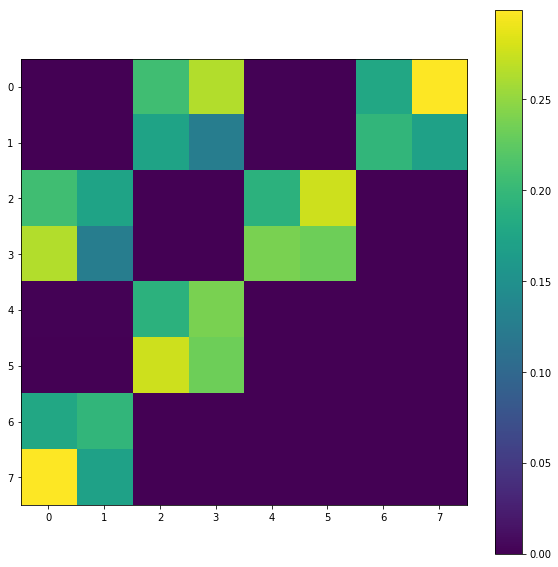

In [5]:
print(data.E)
sg_no_diag = np.copy(data.sig_inv)
for i in range(M):
    sg_no_diag[i*2:i*2+2,i*2:i*2+2] = np.zeros([2,2])
visualize_matrix(np.abs(sg_no_diag))

new_edges = translate_dependencies(data.E)
print("translated edges: ", new_edges)

In [6]:
iterative_deps_mask = []
for i in range(M):
#     iterative_deps_mask.append((2*i,2*i))
#     iterative_deps_mask.append((2*i+1,2*i+1))
#     iterative_deps_mask.append((2*i,2*i+1))
#     iterative_deps_mask.append((2*i+1,2*i))
    iterative_deps_mask.append((2*i,2*i))
    iterative_deps_mask.append((2*i+1,2*i+1))

mu_true = data.mu_true
print(mu_true.shape)
O_true = data.O_true
print(O_true.shape)
p = data.p
O_true_inv = np.linalg.pinv(O_true)

(8, 2)
(8, 8)


### Let's plug this O into our AMC algorithm

In [7]:
from amc_utils import *

In [8]:
mu = solveMatrixCompletionWithMu(O_true_inv,O_true,iterative_deps_mask)

In [9]:
print(mu)

[0.38616819 0.41424099 0.42766355 0.39241534 0.36112299 0.4344358
 0.33905166 0.46346773]


### First iteration of AMC

[(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7)]
Index of largest value:  (2, 3)
Largest value:  5.823090794424967


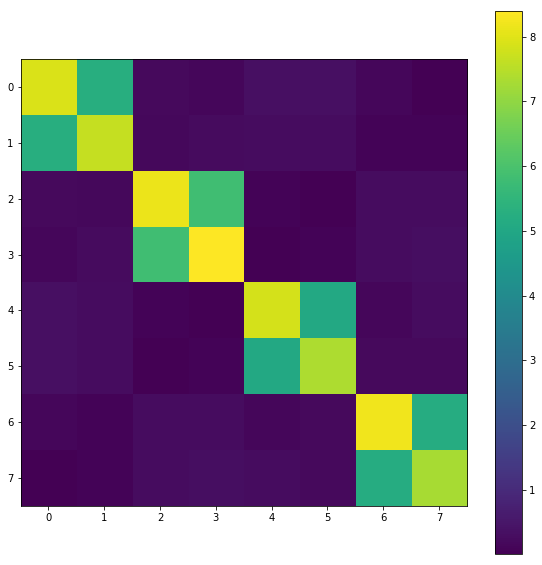

In [10]:
C_synth = O_true - np.outer(mu, mu)
J_synth = np.linalg.pinv(C_synth)
J_clean = copy.deepcopy(J_synth)
# for i in range(M):
#     for j in range(M):
#         if abs(J_clean[i,j]) < 0.3:
#             J_clean[i,j] = 0.0
# print(J_clean)

sg_no_diag = np.copy(J_synth)
# for i in range(M):
#     sg_no_diag[i*2:i*2+2,i*2:i*2+2] = np.zeros([2,2])
visualize_matrix(np.abs(sg_no_diag))

print(iterative_deps_mask)
max_val, max_ind, J_clean = find_largest(O_true,mu,M,iterative_deps_mask,0.1)
print("Index of largest value: ", max_ind)
print("Largest value: ", max_val)

In [11]:
def amc(O, O_inv,iterative_deps_mask,thresh=0.1, nonzeros=3):
    dim = np.shape(O)[0]
#    iterative_deps_mask = samplegrid(dim,dim,nonzeros)
#     try:
#         C_synth = O - np.outer(mu_true, mu_true)
#         J_synth = np.linalg.pinv(C_synth)
#     except:
#         print("Failed to invert J before loop")
#         return np.zeros(np.shape(mu_true)), iterative_deps_mask
    num_iters = 0
    while(True):
        num_iters = num_iters + 1
        starttime = time.time()
        mu = solveMatrixCompletionWithMu(O_inv,O,iterative_deps_mask)
        max_val, max_ind, J_clean = find_largest(O,mu,dim,iterative_deps_mask,thresh)
        #if max_val < 1e-6: return J_distances, mu_distances, max_vals, mu, num_iters
        if max_val < 1e-6: 
            return mu, iterative_deps_mask

        iterative_deps_mask.append(max_ind)
    #return J_distances, mu_distances, max_vals, mu, num_iters
    return mu, iterative_deps_mask

In [12]:
mu, end_deps = amc(O_true,O_true_inv,iterative_deps_mask)
print(end_deps)
diag_set = []
for i in range(M):
    diag_set.append((2*i,2*i))
    diag_set.append((2*i+1,2*i+1))
    diag_set.append((2*i,2*i+1))
    diag_set.append((2*i+1,2*i))
diag_set = set(diag_set)
new_deps = []
for edge in end_deps:
    if edge in diag_set: continue
    new_deps.append(edge)

print(new_deps)

[(0, 0), (1, 1), (2, 2), (3, 3), (4, 4), (5, 5), (6, 6), (7, 7), (2, 3), (3, 2), (1, 0), (7, 6), (5, 4), (0, 1), (6, 7), (4, 5), (0, 7), (7, 0), (1, 7), (7, 1), (1, 6), (6, 1), (0, 6), (6, 0), (0, 3), (3, 0)]
[(0, 7), (7, 0), (1, 7), (7, 1), (1, 6), (6, 1), (0, 6), (6, 0), (0, 3), (3, 0)]


In [13]:
print(new_edges)

[(0, 2), (1, 2), (0, 3), (1, 3), (2, 4), (3, 4), (2, 5), (3, 5), (0, 6), (1, 6), (0, 7), (1, 7)]


In [14]:
print(new_deps)

[(0, 7), (7, 0), (1, 7), (7, 1), (1, 6), (6, 1), (0, 6), (6, 0), (0, 3), (3, 0)]


In [15]:
O = data.rank_one_O
mu_true = data.rank_one_mu
O_inv = np.linalg.pinv(O)
print("edges: ", data.E)

iterative_deps_mask = [(i,i) for i in range(M)]

edges:  [(0, 1), (1, 2), (0, 3)]


In [16]:
C = O - np.outer(mu_true, mu_true)
J = np.linalg.pinv(C)
print(J)

[[-15.52212362 -85.84803813  41.35156732  10.28299144]
 [-85.84803813 -18.09226753   6.55310092  31.39502737]
 [ 41.35156732   6.55310092 -94.12462067 -18.65150892]
 [ 10.28299144  31.39502737 -18.65150892 -48.27725144]]
